### This Notebook is for summarizing the Single Document 'Text Summarization' based on TFIDF Sentence scoring and Centroid Based Scoring System


## TF-IDF based summarizer (Extractive summary) :
    Step 1: Text preprocessing ( Sentence Tokenization, Word Tokenization, Stop words and regular expression removal)
    Step 2:TF-IDF calculation
    Step 3:Sentence Scoring based on the TF-IDF score
    Step 4:Sentence Extraction based on average sentence score
    Step 5:ROUGE-1 Evaluation (With reference to Reference Summarized Text)

## Centroid based summarizer (Extractive summary) :
    Step 1: Text preprocessing ( Sentence Tokenization, Word Tokenization, Stop words and
            regular expression removal)
    Step 2: TF-IDF calculation
    Step 3: Centroid Vector extraction (Considered those words, which have TF-IDF score greater 
            than averge TF-IDF Score)
    Step 4: Sentence Vector (Considered the all the words in sentence along with its TF-IDF Score)
    Step 5: Sentence similarity score by using Cosine Similarity 
    Step 6: Sentence Extraction based on average sentence similarity score
    Step 7: ROUGE-1 Evaluation (With reference to Reference Summarized Text)

In [138]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
import math
import os

In [139]:
#List of stopwords
stopwords_eng = stopwords.words('english')

In [142]:
# Loading the data
df=pd.read_csv('train.csv')
df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [143]:
def text_preprocessing(text):
    """This function will do following preprocessing
    1. Tokenizing the text into sentence.
    2. Word tokenization for each sentence tokens.
    3. Removing the stop words
    4. Removing the regular expression
    5. Output format: cleaned_text={'sent1':['word1','word2'....],'sent2':['w1,'w2','w3',..]}
     """
    sent_token=sent_tokenize(text)
    n=len(sent_token)
    cleaned_text={}
    for i in range(0,n):
        temp=[]
        w_t=word_tokenize(sent_token[i])
        w_t_s=[word for word in w_t if ((not word.lower() in stopwords_eng )and (len(word)>3))]
        for word in w_t_s:
            result = re.sub(r'[^a-zA-Z]', '',word)
            if result!='':
                temp.append(result.lower())
            else:
                continue
        if len(temp)>3:
            cleaned_text[sent_token[i]]=temp
    return cleaned_text
    

In [144]:
def frequency_count(cleaned_text):
    """This function return the frequency of each word in the given sentence
    Input_argument:
                cleaned_text={'sent1':['word1','word2'....],'sent2':['w1,'w2','w3',..]}
    Output:
          freq_dict={'sent1':{'word1':count1,'word2':count2....},'sent2':{'word1':count1,....} 
    """
    freq_dict={}
    for i in cleaned_text.keys():
        freq_dict[i]={}
        for j in cleaned_text[i]:
            if j not in freq_dict[i].keys():
                freq_dict[i][j]=1
            else:
                freq_dict[i][j]=freq_dict[i][j]+1
                
    return freq_dict

In [145]:
def tf_score(cleaned_text,freq_dict):
    '''This function is for the term frequency
       Output:
       tf_dict={'sent1':{'word1':tf1,'word2':tf2....},'sent2':{'word1':tf1,....}
    '''
    tf_dict={}
    for i in freq_dict.keys():
        tf_dict[i]={}
        for j in freq_dict[i].keys():
            tf_dict[i][j]=round(freq_dict[i][j]/len(cleaned_text[i]),3)
    return tf_dict

In [146]:
def doc_word_freq(cleaned_text):
    """This return how many times particular word appeared in the document.
    """
    doc_freq={}
    for i in cleaned_text.keys():
        doc_freq[i]={}
        for j in cleaned_text[i]:
            count=0
            if j not in doc_freq[i].keys():
                doc_freq[i][j]=0     
            else:
                continue
            for k in cleaned_text.keys():
                if j in cleaned_text[k]:
                    count=count+1
                else:
                    continue
            doc_freq[i][j]=count
    return doc_freq
            
                

In [147]:
def idf_score(cleaned_text,freq_dict):
    'This function will return the Inverse Document Frequency for the each word in a sentence'
    idf_dict={}
    doc_freq=doc_word_freq(cleaned_text)
    n_sent=len(freq_dict.keys())
    for i in freq_dict.keys():
        idf_dict[i]={}
        for j in freq_dict[i].keys():
            idf_dict[i][j]=math.log(n_sent/doc_freq[i][j])
    return idf_dict

In [148]:
def tf_idf_score(tf_dict,idf_dict):
    'This function will return tf-idf value for each word in a sentence'
    tf_idf_dict={}
    for i in tf_dict.keys():
        tf_idf_dict[i]={}
        for j in tf_dict[i].keys():
            tf_idf_dict[i][j]=tf_dict[i][j]*idf_dict[i][j]
    return tf_idf_dict

In [149]:
def sent_score(tf_idf_dict):
    """This function will return weight or score for each sentence by adding the 
       tf-idf values of each word in a sentence and normalized by the number of words in a sentence.
    """
    sent_tfidf_dict={}
    for i in tf_idf_dict.keys():
        sum=0
        for j in tf_idf_dict[i].keys():
            sum=sum+tf_idf_dict[i][j]
        sent_tfidf_dict[i]=sum/len(tf_idf_dict[i].keys())
    return sent_tfidf_dict

In [150]:
def sent_avg_score(sent_tfidf_dict):
    """ This function will return average score of sentence.
    """
    avg_score=0
    n=len(sent_tfidf_dict.keys())
    sum=0
    for i in sent_tfidf_dict.keys():
        sum=sum+sent_tfidf_dict[i]
    avg_score=sum/n
    return avg_score
    

In [151]:
def summarize(sent_tfidf_dict,tuning_factor):
    """ This function will return the summarized text"""
    summary=''
    summary_dict={}
    avg_score=sent_avg_score(sent_tfidf_dict)
    for i in sent_tfidf_dict.keys():
        if sent_tfidf_dict[i]>tuning_factor*avg_score:
            summary=summary+i
    return summary

In [152]:
def tfidf_summarizer(text,tuning_factor):
    'This is main driving function. It takes raw text and return summary'
    cleaned_text=text_preprocessing(text)
    freq_dict=frequency_count(cleaned_text)
    tf_dict=tf_score(cleaned_text,freq_dict)
    doc_freq=doc_word_freq(cleaned_text)
    idf_dict=idf_score(cleaned_text,freq_dict)
    tf_idf_dict=tf_idf_score(tf_dict,idf_dict)
    sent_sc=sent_score(tf_idf_dict)
    summary=summarize(sent_sc,tuning_factor)
    return summary
    
    

In [153]:
def avg_centroid_score(centroid):
    sum=0
    for i in centroid.keys():
        sum=sum+centroid[i]
    avg_score=sum/len(centroid.keys())
    return avg_score

In [154]:
def text_centroid(tf_idf_dict):
    centroid={}
    new_centroid={}
    for i in tf_idf_dict.keys():
        for j in tf_idf_dict[i].keys():
            if j not in centroid.keys():
                centroid[j]=tf_idf_dict[i][j]
            else:
                centroid[j]=tf_idf_dict[i][j]+centroid[j]
    avg_score=avg_centroid_score(centroid)
    for i in centroid.keys():
        if centroid[i]>avg_score:
            new_centroid[i]=centroid[i]
        else:
            continue
    
    return new_centroid

In [155]:
def sent_cos_similarity(tf_idf_dict):
    new_centroid=text_centroid(tf_idf_dict)
    sent_similarity={}
    mod_centroid=0
    sq_sum=0
    for i in new_centroid.keys():
        sq_sum=sq_sum+new_centroid[i]**2
    mod_centroid=math.sqrt(sq_sum)
    for j in tf_idf_dict.keys():
        mod_sent=0
        sq_sum=0
        dot_product=0
        for k in tf_idf_dict[j].keys():
            sq_sum=sq_sum+tf_idf_dict[j][k]**2
            if k in new_centroid.keys():
                dot_product=dot_product+tf_idf_dict[j][k]*new_centroid[k]
        mod_sent=math.sqrt(sq_sum)
        sent_similarity[j]=round(dot_product/(mod_centroid*mod_sent),3)
            
    return sent_similarity

In [156]:
def avg_sent_similarity(sent_similarity):
    n=len(sent_similarity.keys())
    sum=0
    for i in sent_similarity:
        sum=sum+sent_similarity[i]
    avg_score=sum/n
    
    return avg_score
        

In [157]:
def centroid_summary_gen(sent_similarity,tuning_factor):
    avg_score=avg_sent_similarity(sent_similarity)
    summary=''
    for i in sent_similarity:
        if sent_similarity[i]>tuning_factor*avg_score:
            summary=summary+str(i)
        else:
            continue
    return summary

In [158]:
def ROUGE_1(sys_summarized_text,ref_summarized_text):
    sys_text=text_preprocessing(sys_summarized_text)
    ref_text=text_preprocessing(ref_summarized_text)
    sys_word=[]
    ref_word=[]
    match_count=0
    for i in sys_text.keys():
        for j in sys_text[i]:
            sys_word.append(j)
    for i in ref_text.keys():
        for j in ref_text[i]:
            ref_word.append(j)
    n=len(ref_word)
    for i in sys_word:
        for j in range(len(ref_word)):
            if i==ref_word[j]:
                match_count=match_count+1
                ref_word.pop(j)
                break
            else:
                continue
    if n>0:
        ROUGE=match_count/n
    else:
        ROUGE=0
    return ROUGE

In [159]:
def centroid_summarizer(text,tuning_factor):
    cleaned_text=text_preprocessing(text)
    freq_dict=frequency_count(cleaned_text)
    tf_dict=tf_score(cleaned_text,freq_dict)
    doc_freq=doc_word_freq(cleaned_text)
    idf_dict=idf_score(cleaned_text,freq_dict)
    tf_idf_dict=tf_idf_score(tf_dict,idf_dict)
    centroid=text_centroid(tf_idf_dict)
    sent_similarity=sent_cos_similarity(tf_idf_dict)
    summary=centroid_summary_gen(sent_similarity,tuning_factor)
    return summary

In [160]:
## Whole text as summary
n=len(df)
ROUGE_dict_max={}
sum=0
for i in range(n):
    tuning_factor=0  #Range (1 to 1.2)
    ref_summarized_text=df['highlights'][i]
    sys_summarized_text=tfidf_summarizer(df['article'][i],tuning_factor)
    ROUGE=ROUGE_1(sys_summarized_text,ref_summarized_text)
    ROUGE_dict_max[df['id'][i]]=ROUGE
    sum=sum+ROUGE
print('ROUGE_avg_score_max(If whole text as summary):',sum/n)

ROUGE_avg_score_max(If whole text as summary): 0.7883746023832297


In [161]:
## TFidf based summary evaluation

n=len(df)
ROUGE_dict_tfidf={}
sum=0
for i in range(n):
    tuning_factor=1.1 # Range (1 to 1.2)
    ref_summarized_text=df['highlights'][i]
    sys_summarized_text=tfidf_summarizer(df['article'][i],tuning_factor)
    ROUGE=ROUGE_1(sys_summarized_text,ref_summarized_text)
    ROUGE_dict_tfidf[df['id'][i]]=ROUGE
    sum=sum+ROUGE
print('ROUGE_avg_score_tfidf:',sum/n)

ROUGE_avg_score_tfidf: 0.22815099933859012


In [162]:
## centroid based summary 
n=len(df)
ROUGE_dict_centroid={}
sum=0
for i in range(n):
    tuning_factor=1.1 ## Range (1 to 1.2)
    ref_summarized_text=df['highlights'][i]
    sys_summarized_text=centroid_summarizer(df['article'][i],tuning_factor)
    ROUGE=ROUGE_1(sys_summarized_text,ref_summarized_text)
    ROUGE_dict_centroid[df['id'][i]]=ROUGE
    sum=sum+ROUGE
print('ROUGE_avg_Score_centroid',sum/n)

ROUGE_avg_Score_centroid 0.4562245732999075


In [163]:
index=0
Y_max=[]
Y_centroid=[]
Y_tfidf=[]
X=[]
for i in ROUGE_dict_tfidf.keys():
    Y_max.append(ROUGE_dict_max[i])
    Y_centroid.append(ROUGE_dict_centroid[i])
    Y_tfidf.append(ROUGE_dict_tfidf[i])
    X.append(index)
    index=index+1

In [164]:
import matplotlib.pyplot as plt

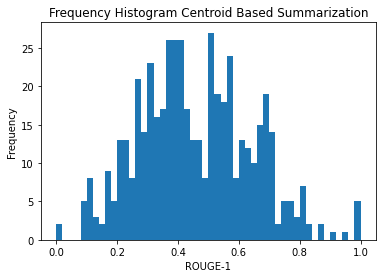

In [165]:
# Plot Histogram on x
plt.hist(Y_centroid, bins=50)
plt.gca().set(title='Frequency Histogram Centroid Based Summarization', ylabel='Frequency',xlabel='ROUGE-1');


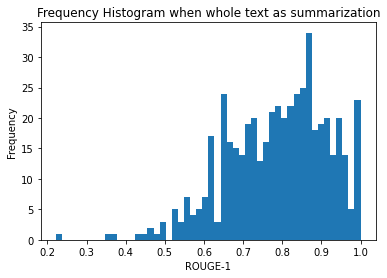

In [166]:
# Plot Histogram on x
plt.hist(Y_max, bins=50)
plt.gca().set(title='Frequency Histogram when whole text as summarization', ylabel='Frequency',xlabel='ROUGE-1');

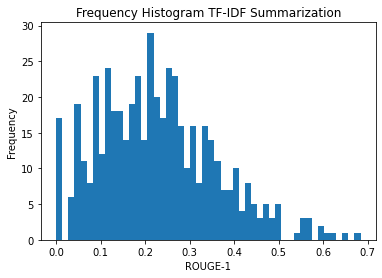

In [167]:
# Plot Histogram on x
plt.hist(Y_tfidf, bins=50)
plt.gca().set(title='Frequency Histogram TF-IDF Summarization', ylabel='Frequency',xlabel='ROUGE-1');

In [168]:
#Sample summary result
i=215
ref_summarized_text=df['highlights'][i]
centroid_summary=centroid_summarizer(df['article'][i],1.2)
tf_idf_summary=tfidf_summarizer(df['article'][i],1.1)
print('Original Text:\n')
print(df['article'][i])
print('\n\n')
print('TF_IDF Based Summary:\n')
print(tf_idf_summary)
print('\n\n')
print('Centroid Based Summary:\n')
print(centroid_summary)
print('\n\n')
print('Reference Summarized Text(Abstractive):\n')
print(ref_summarized_text)

Original Text:

(CNN) -- Canadian aviation company Bombardier is taking a "major bet" on the notoriously cut-throat passenger plane market, spending around $3.5 billion to compete with well-established rivals Boeing and Airbus, its chief executive Guy Hachey says. The money will be invested in Bombardier's new C Series aircraft, which has the capacity to seat 100 to 150 passengers. Bombardier faces obstacles, including the dominance of its competitors in the market and the eurozone financial crisis, which has hit the aviation industry hard. But the company is in a strong position to target a market that has been "under-served" by the major players, Hachey said. Watch: How to buy planes . "So far, we've been serving customers up to about 100 seats, more in the regional segment. Now we're cracking into more of the mainline segment. We're investing about $3.5 billion -- for the size of our company that is a very significant investment," he told CNN. "If you look at our company we have two

## Conclusion:
    From above it is evident that centorid based method is able to capture better main idea of the text than the tf_idf method.
    Based on 500 instances:
    i) Maximum achievable average ROUGE-1 score: 0.78 (When whole text as summary)
    ii) Average ROUGE-1 TF-IDF based summarizer: 0.45
    iii) Average ROUGE-1 Centroid based summarizer: 0.22